## Sydney Basin Thunderstorm Climatology based on GPATS data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

get_ipython().run_line_magic('matplotlib', 'inline')
# %matplotlib notebook for interactivity
import utility_functions_sep2018 as bous

'''
Just change station id variable to generate plots for other airports
'''

cur_dir='/home/bou/shared/stats-R/flask_projects/avguide/app/data'
cur_dir='/home/accounts/qdisplay/avguide/app/data'

In [2]:
sta='YSSY' # change to explore fog plots for other locations
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
# resample data to 1 min (just minimises memory footprint/performance)
# no real impact to data interpretatability
g_ms = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')
print(g_ms.info())
# 41119 gpats strikes , 1.3MB memory footprint
g_ms.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41119 entries, 2008-02-26 06:13:58.524000 to 2020-09-21 11:28:29.815000
Data columns (total 3 columns):
LATITUDE     41119 non-null float64
LONGITUDE    41119 non-null float64
AMP          41119 non-null float64
dtypes: float64(3)
memory usage: 1.3 MB
None


,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:20:17.668,-34.10306,151.07315,-29.9
2020-09-21 11:21:09.725,-34.09893,151.04572,-13.6
2020-09-21 11:21:58.776,-34.07595,151.05222,50.4
2020-09-21 11:23:25.179,-34.02961,151.17613,-14.2
2020-09-21 11:23:25.212,-34.01039,151.12048,-13.8
2020-09-21 11:23:25.260,-34.00524,151.12358,-14.9
2020-09-21 11:24:23.725,-34.10694,151.11787,-27.5
2020-09-21 11:25:35.909,-34.10696,151.10039,-65.3
2020-09-21 11:25:35.953,-34.10568,151.06783,41.7


In [3]:
sta='YSSY' # change to explore fog plots for other locations
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
# resample data to 1 min (just minimises memory footprint/performance)
# no real impact to data interpretatability
# but it puts a limit to gpats in any given hour <=60  
# so when we normalise by say total number of TS days - mean shud be also <= 60
# and good way to compare activiy across hours
g = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
    .resample('1min')\
    .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
    .dropna()
print(g.info())
# 10930 rows/gpats strikes , 341kB Vs 1.3MB - almost 1/5 of raw dataset   
g.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10930 entries, 2008-02-26 06:13:00 to 2020-09-21 11:28:00
Data columns (total 3 columns):
LATITUDE     10930 non-null float64
LONGITUDE    10930 non-null float64
AMP          10930 non-null int64
dtypes: float64(2), int64(1)
memory usage: 341.6 KB
None


,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:21:00,-34.08744,151.048970,2
2020-09-21 11:23:00,-34.01508,151.140063,3
2020-09-21 11:24:00,-34.10694,151.117870,1
2020-09-21 11:25:00,-34.10632,151.084110,2
2020-09-21 11:28:00,-34.05155,151.145890,1


In [4]:
# To find days with gpats - resample('D') 
# NB: resample introduce "ALL" days regardless whether gpats data or not 
# g_ms.resample('D')['AMP'].count() - if using raw millisecond gpats data
g.resample('D')['AMP'].sum().tail(10)

TM
2020-09-12     0
2020-09-13     0
2020-09-14     0
2020-09-15     0
2020-09-16     0
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    26
Freq: D, Name: AMP, dtype: int64

In [5]:
# We drop those days with no strikes or even 1 strike (cud be spurious)
# note a sum() here is appropriate, as would be count() but with lower values obviously
g_tmp = g.resample('D')['AMP'].count()
ts_days = g_tmp.loc[g_tmp>1]
print(f'Number of TS days in Sydney {ts_days.index[0].strftime("%b-%Y")} to\
{ts_days.index[-1].strftime("%b-%Y")} = {ts_days.shape[0]} days')
ts_days.tail(10)

Number of TS days in Sydney Feb-2008 toSep-2020 = 384 days


TM
2020-05-13    13
2020-05-21    24
2020-06-07     4
2020-06-21     3
2020-07-02     2
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64

In [6]:
# To get number of days with TS in each month,
# group by month and count days with TS to get monthly summaries
# sum() not appripriate here as this would ADD up all gpats strikes
# we want to add days, not gpats strikes in days

g_month = ts_days.groupby(ts_days.index.month).count()
g_month

TM
1     47
2     44
3     44
4     31
5     17
6     21
7     16
8     13
9     19
10    38
11    47
12    47
Name: AMP, dtype: int64

In [7]:
# We can normalise monthly gpats count if we divide by number of thunder days 
# in given month to get sense of how lightning active each month is
# Dec and Jan is most lightning active, followed 2nd place Nov, then 3rd place Feb/Mar 
# 1st get count raw strikes without any resampling to min or hour
g_ms = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')
g_tmp = g_ms.resample('D')['AMP'].count() 
g_tmp_days = g_tmp.loc[g_tmp>1]
g_month_activity = g_tmp_days.groupby(g_tmp_days.index.month).sum()
g_month_activity = ts_days.groupby(ts_days.index.month).sum()
round(g_month_activity/g_month)

TM
1     40.0
2     32.0
3     31.0
4     24.0
5     21.0
6     12.0
7     11.0
8     15.0
9     18.0
10    21.0
11    37.0
12    35.0
Name: AMP, dtype: float64

In [8]:
# Normalise total monthly thunder days (divide by num of years) to average monthly thunder days
# rounded to 1 DP, Nov,Dec,Jan on average has about 4 thunder days every year
# Oct, Feb, Mar not too far behind (avg ~ 3.5 thunder days) 
round((g_month/12),1)

TM
1     3.9
2     3.7
3     3.7
4     2.6
5     1.4
6     1.8
7     1.3
8     1.1
9     1.6
10    3.2
11    3.9
12    3.9
Name: AMP, dtype: float64

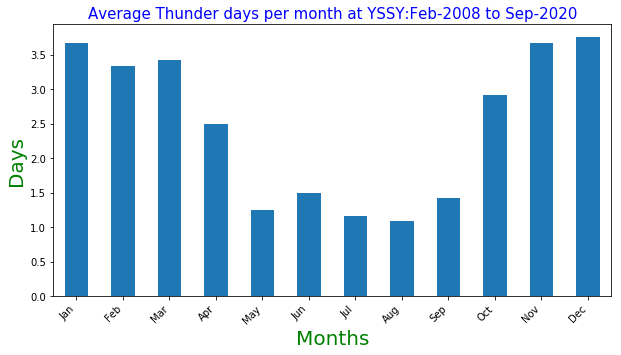

In [9]:
# see Fig 1.1 http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# that figure is for 1939 to 2014 Average Thunder days per nonth
# trends are similar - peak about 4.0 in Nov/Dec/Jab, so 4 days with TS in these months (about 13%)
# we have more broad peak Jan to Mar and Oct to Dec

dict_mon = dict(zip(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))

dat = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
    .resample('D')['AMP'].count()
ts_days = dat.loc[dat>2]
avg_mon_ts_days = ts_days.groupby(ts_days.index.month).count()/12


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
avg_mon_ts_days.plot( kind='bar', ax=ax)
title = f'Average Thunder days per month at YSSY:\
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Days', color='g', fontsize=20)
ax.set_xlabel('Months', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[dict_mon[x+1] for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [10]:
# Assuming 30 days per month, this is the climatological probability storms 
# in any given month
# Nov,Dec,Jan has 13% chance of storms on any given day - quite high!
# Is this the correct way to do this???
round((g_month/(12*30))*100,2)

TM
1     13.06
2     12.22
3     12.22
4      8.61
5      4.72
6      5.83
7      4.44
8      3.61
9      5.28
10    10.56
11    13.06
12    13.06
Name: AMP, dtype: float64

In [11]:
# Average thunder days annually (bit more than what average annual thunder days map suggests)
# see climate_averages thunder-lightning map below
sum(g_month/12)

32.0

## http://www.bom.gov.au/climate/averages/climatology/thunder
- based on analysis using 10 years of data 1990 to 1999 
- about 20 years old data so not as reliable probably

![](http://www.bom.gov.au/climate/averages/climatology/thunder/tdays.png)

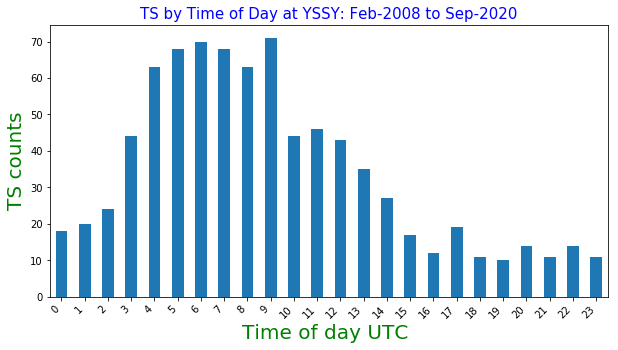

In [12]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
# see also fig 1.2  http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# very similar trends to whats here

g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()

# we get max 1 gpats count for any minute , so its either 0 or 1 for every minute
# giving max gpats count 60 in an hour, anything in range 0 to 60 in an hour 

# actually this gives same result without the double resample hassles
#g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
#          .resample('H')['AMP'].count()

g1_hour = g1_hour.loc[g1_hour>1]
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count() # NB not sum() !

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'TS by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('TS counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

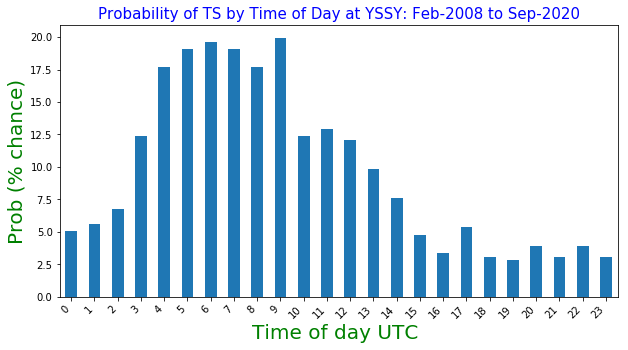

In [13]:
# Normalise - just divide by number of TS days
# Note not all days will have TS at all hours of the day
# EG Some days TS only between 4 to 10Z
gpats_by_hour = (gpats_by_hour/ts_days.shape[0])*100
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'Probability of TS by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Prob (% chance)', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
xlabels=[x for x in ax.get_xticks()]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

We can see that the highest chance of TS (about 16 to 18%) is between 4 to 9Z (2pm to 7pm) and failry low after 16Z 2am in t emorning hours.

In [14]:
dict_mon
keys = list(dict_mon.keys())
vals = list(dict_mon.values())
print(keys[vals.index('Oct')])
print(keys[vals.index('Nov')])

10
11


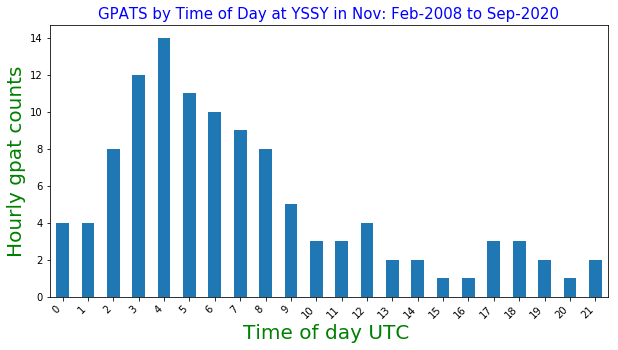

In [15]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()

# actually this gives same result without the double resample hassles
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()

g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour

# hourly trend for October only
mon=keys[vals.index('Nov')]
g1_hour = g1_hour.loc[g1_hour.index.month==mon]  
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta} in {dict_mon[mon]}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

For month of October, on average 
- storms observed about 6 days in Oct hours 3-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 3 to 7Z

In [16]:
'''
resample data to 1min
 nb the counts would obviously be smaller given we not counting millisecond precision strikes
 good thing is we get max 1 gpats count for any minute , so its either 0 or 1
 giving max gpats count 60 in an hour, anything in range 0 to 60
'''
g1_day = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
      .resample('1min')\
      .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
      .dropna()\
      .resample('D')['AMP'].count()
g1_day.tail()

TM
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    11
Freq: D, Name: AMP, dtype: int64

In [17]:
# drop days with no gpats
g1_day = g1_day.loc[g1_day>2]
g1_day.tail(10)

TM
2020-04-30     5
2020-05-13    13
2020-05-21    24
2020-06-07     4
2020-06-21     3
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64

In [18]:
g1_month = g1_day.groupby(g1_day.index.month).count()
g1_month

TM
1     43
2     39
3     41
4     28
5     15
6     16
7     13
8     13
9     16
10    34
11    44
12    45
Name: AMP, dtype: int64

In [19]:
# note resample introduces hours in dataset even when no gpats
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').\
          resample('H')['AMP'].count()
g1_hour.tail()

TM
2020-09-21 07:00:00     0
2020-09-21 08:00:00     0
2020-09-21 09:00:00     0
2020-09-21 10:00:00     1
2020-09-21 11:00:00    25
Freq: H, Name: AMP, dtype: int64

In [20]:
# to check out any specific day - gpats count for each hour on that date
g1_hour.loc['29-03-2008']

TM
2008-03-29 00:00:00     0
2008-03-29 01:00:00     0
2008-03-29 02:00:00     0
2008-03-29 03:00:00     0
2008-03-29 04:00:00     0
2008-03-29 05:00:00     0
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 08:00:00     0
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 13:00:00     0
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
2008-03-29 16:00:00     0
2008-03-29 17:00:00     0
2008-03-29 18:00:00     0
2008-03-29 19:00:00     0
2008-03-29 20:00:00     0
2008-03-29 21:00:00     0
2008-03-29 22:00:00     0
2008-03-29 23:00:00     0
Freq: H, Name: AMP, dtype: int64

In [21]:
# drop hours when no gpats
g1_hour = g1_hour[g1_hour>0]
g1_hour.loc['29-03-2008']

TM
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
Name: AMP, dtype: int64

In [22]:
# get gpats count by hour for for each hour over all days/years
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
gpats_by_hour/24

TM
0     1.208333
1     1.250000
2     1.541667
3     2.458333
4     3.500000
5     3.750000
6     3.666667
7     3.500000
8     3.750000
9     3.875000
10    2.500000
11    2.583333
12    2.375000
13    1.875000
14    1.833333
15    1.166667
16    0.750000
17    1.125000
18    0.916667
19    0.791667
20    0.916667
21    0.625000
22    0.875000
23    0.833333
Name: AMP, dtype: float64

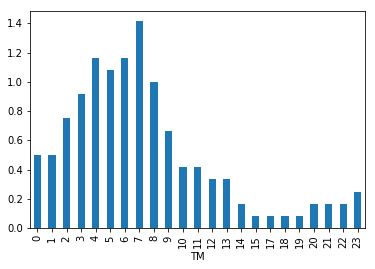

In [23]:
# November hourly trend 
mon=keys[vals.index('Dec')]
g1_dec = g1_hour.loc[g1_hour.index.month==mon]
(g1_dec.groupby(g1_dec.index.hour).count()/12).plot(kind='bar')

For month of November, on average 
- storms observed about 7 days in Oct hours 2-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 4 to 7Z , about 15 to 18 days have storms on average between these hours in Nov!

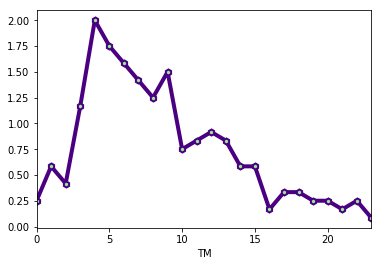

In [24]:
# to see hourly variation by season
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()
g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour

spring = (g1_hour.index.month == 9) | (g1_hour.index.month == 10) | (g1_hour.index.month == 11)
summer = (g1_hour.index.month == 12) | (g1_hour.index.month == 1) | (g1_hour.index.month == 2)
autumn = (g1_hour.index.month == 3) | (g1_hour.index.month == 4) | (g1_hour.index.month == 5)
winter = (g1_hour.index.month == 6) | (g1_hour.index.month == 7) | (g1_hour.index.month == 8)

g1_spring = g1_hour.loc[spring]
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='#4b0082', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

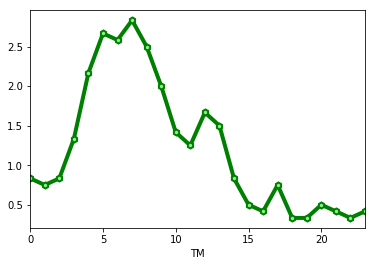

In [25]:
g1_summer = g1_hour.loc[summer]
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='green', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

Text(0.5, 0, 'Time of day UTC ')

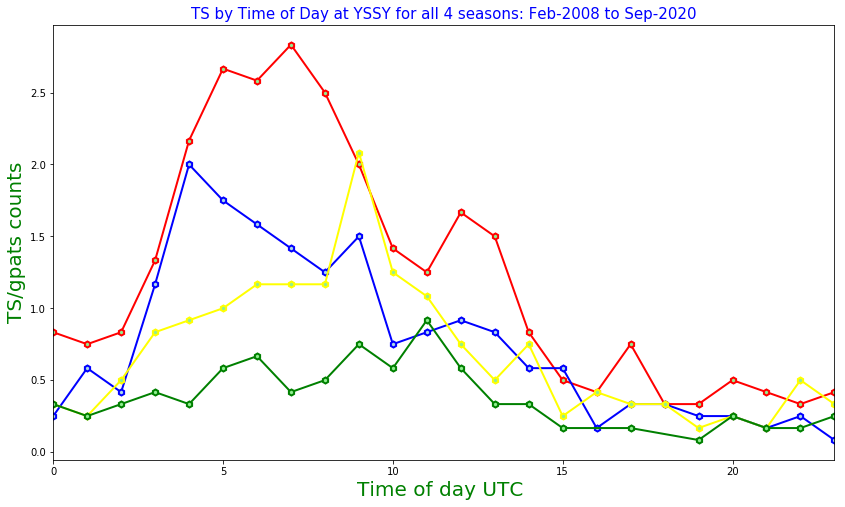

In [26]:

g1_autumn = g1_hour.loc[autumn]

g1_winter = g1_hour.loc[winter]

fig, ax = plt.subplots(figsize=(14,8), nrows=1, ncols=1 )


(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='red', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='blue', linewidth=2,
         marker='h', markerfacecolor='lightblue', markeredgewidth=2)
(g1_autumn.groupby(g1_autumn.index.hour).count()/12).plot(kind='line', color='yellow', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

(g1_winter.groupby(g1_winter.index.hour).count()/12).plot(kind='line', color='green', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

title = f'TS by Time of Day at {sta} for all 4 seasons: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('TS/gpats counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)

In [27]:
# def get_gpats_data(cur_dir:str="./gpats_data/",sta:str="YBBN")->pd.DataFrame:
yssy = bous.get_gpats_data(cur_dir=cur_dir,sta='YSSY')\
       .resample('D')['AMP'].count()
yssy = yssy.loc[yssy>1]  # only count days as storm days if more than 2 gpats regsitered
print(yssy.tail())
print(f'Number of storm days in YSSY {len(yssy.index)},  {len(set(yssy.index))}')

ysri = bous.get_gpats_data(cur_dir=cur_dir,sta='YSRI')\
       .resample('D')['AMP'].count()
ysri = ysri.loc[ysri>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysri.tail())
print(f'Number of storm days in ysri {len(ysri.index)},  {len(set(ysri.index))}')

yscn = bous.get_gpats_data(cur_dir=cur_dir,sta='YSCN')\
       .resample('D')['AMP'].count()
yscn = yscn.loc[yscn>1]  # only count days as storm days if more than 2 gpats regsitered
print(yscn.tail())
print(f'Number of storm days in ysbk {len(yscn.index)},  {len(set(yscn.index))}')


ysbk = bous.get_gpats_data(cur_dir=cur_dir,sta='YSBK')\
       .resample('D')['AMP'].count()
ysbk = ysbk.loc[ysbk>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysbk.tail())
print(f'Number of storm days in ysbk {len(ysbk.index)},  {len(set(ysbk.index))}')

yshw = bous.get_gpats_data(cur_dir=cur_dir,sta='YSHW')\
       .resample('D')['AMP'].count()
yshw = yshw.loc[yshw>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshw.tail())
print(f'Number of storm days in yshw {len(yshw.index)},  {len(set(yshw.index))}')

yshl = bous.get_gpats_data(cur_dir=cur_dir,sta='YSHL')\
       .resample('D')['AMP'].count()
yshl = ysri.loc[yshl>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshl.tail())
print(f'Number of storm days in yshl {len(yshl.index)},  {len(set(yshl.index))}')

ywlm = bous.get_gpats_data(cur_dir=cur_dir,sta='YWLM')\
       .resample('D')['AMP'].count()
ywlm = ywlm.loc[ywlm>1]  # only count days as storm days if more than 2 gpats regsitered
print(ywlm.tail())
print(f'Number of storm days in ywlm {len(ywlm.index)},  {len(set(ywlm.index))}')


Reading YSSY gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64
Number of storm days in YSSY 384,  384
Reading YSRI gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSRI_10NM.csv
TM
2020-05-21    9
2020-07-13    6
2020-08-08    6
2020-08-12    5
2020-09-04    3
Name: AMP, dtype: int64
Number of storm days in ysri 397,  397
Reading YSCN gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSCN_10NM.csv
TM
2020-04-29     2
2020-05-21    18
2020-07-13     3
2020-08-12     5
2020-09-21    31
Name: AMP, dtype: int64
Number of storm days in ysbk 342,  342
Reading YSBK gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSBK_10NM.csv
TM
2020-07-12     7
2020-07-13     5
2020-08-08     5
2020-08-12     8
2020-09-21    25
Name: AMP, dtype: int64
Number of storm days in ysbk 353,  353
Reading YSHW gpats file /home/accounts/qdisplay/avguide/app/d

Get relative frequeccies
How often SYd gets storms given there are storms at YSRI
COnditional probabilities

Storms YSSY given TS at YSRI
- P(TS YSSY | TS YSRI)
- P(TS YSSY | TS YSCN)

storms at Banks and Holls given TS Camden

- P(TS YSBK | TS YSCN)  or 
- P(TS YSHW | TS YSCN)


Load gpats - get TS dates and set arithmatic to get conditionals

In [28]:
yssy.index

DatetimeIndex(['2008-02-26', '2008-02-27', '2008-02-28', '2008-03-07',
               '2008-03-20', '2008-03-23', '2008-03-25', '2008-03-29',
               '2008-04-13', '2008-05-13',
               ...
               '2020-05-13', '2020-05-21', '2020-06-07', '2020-06-21',
               '2020-07-02', '2020-07-12', '2020-07-13', '2020-08-12',
               '2020-09-04', '2020-09-21'],
              dtype='datetime64[ns]', name='TM', length=384, freq=None)

In [29]:
# removing duplicated from list  
# using collections.OrderedDict.fromkeys() 
from collections import OrderedDict 
res = list(OrderedDict.fromkeys(yssy.index)) 
res[-10:]

[Timestamp('2020-05-13 00:00:00'),
 Timestamp('2020-05-21 00:00:00'),
 Timestamp('2020-06-07 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-07-02 00:00:00'),
 Timestamp('2020-07-12 00:00:00'),
 Timestamp('2020-07-13 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-09-21 00:00:00')]

In [30]:
'''
easiest way by which the duplicates are removed from the list - use set()
main drawback is that the ordering of the element is lost in this particular method - 
not too concerned with that here.

set(A).union(set(B)),
set(A).intersection(set(B)),
set(A).symmetric_difference(set(B)),
set(A).difference(set(B)),
set(A).difference(set(B)))
'''

# 227 storm dates in common with ysri and yssy, 20 dates when storms possibly only at ysri
print(f'Number of days with storms at YSRI:{len(set(ysri.index))}\n\
Number of days with storms at YSSY:{len(set(yssy.index))}\n\
Number of days with storms at both locations: {len(set(ysri.index).intersection(set(yssy.index)))}')

Number of days with storms at YSRI:397
Number of days with storms at YSSY:384
Number of days with storms at both locations: 251


In [31]:
# set symmetric_difference - dates which are not common to both sets (associative)
# dates which appear in either one of the sets but not in both 
# (so not common or opposite of intersection)
print(f'Number of days storms at only YSSY or only YSRI but not at both locations \
{len(set(ysri.index).symmetric_difference(set(yssy.index)))},\
{len(set(yssy.index).symmetric_difference(set(ysri.index)))}')

Number of days storms at only YSSY or only YSRI but not at both locations 279,279


In [32]:

'''
From these 260 days, how many are in yssy alone and hom many in ysri only
The set difference of A and B is a set of dates that exists only in set A but not in B'''
print(f'Number of days storms only at YSRI (and not at YSSY) \
{len(set(ysri.index).difference(set(yssy.index)))}')

print(f'Number of days storms only at YSSY (and not at YSRI) \
{len(set(yssy.index).difference(set(ysri.index)))}')

Number of days storms only at YSRI (and not at YSSY) 146
Number of days storms only at YSSY (and not at YSRI) 133


In [33]:
'''
ysri had 367 storm days, yssy 347 days, of these common dates
i.e Number of days with storms at both locations = 227

Out of these, 140 days when storm only at YSRI but not at YSSY
We want to find out how many days we get storms at YSSY given they were also observed at YSRI

Simple approach 
1. find all dates when had stormsa at YSRI - call this number a
2. find how mnay of these dates storms also at YSSY - b num of days
3. conditional prob P(storm YSSY | storm at YSI) = b/a
'''
print (f'probability of TS at YSSY given TS at YSRI = \
{(len(set(ysri.index)) - len(set(ysri.index).difference(set(yssy.index)))) / len(set(ysri.index)):.2f} or \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')



probability of TS at YSSY given TS at YSRI = 0.63 or 0.63


In [34]:
print (f'probability of TS at YSSY given TS at YSRI = \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSCN =\
 {len(set(yscn.index).intersection(set(yssy.index))) / len(set(yscn.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSBK =\
 {len(set(ysbk.index).intersection(set(yssy.index))) / len(set(ysbk.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSHW =\
 {len(set(yshw.index).intersection(set(yssy.index))) / len(set(yshw.index)):.2f}')

probability of TS at YSSY given TS at YSRI = 0.63
probability of TS at YSSY given TS at YSCN = 0.71
probability of TS at YSSY given TS at YSBK = 0.86
probability of TS at YSSY given TS at YSHW = 0.82


THis means that off all the storms that affect YSRI, 63% go on to affect YSSY also,
If a storm is at YSBK, than there is 86% chance that storms will also affect YSSY
Whether these are the same storms or not can be found by comparing TS onset times at two locations
with the condition that storm at upstream locations occurs before storm at downwind  location. 

However 65% of days when have storms at YSSY, we also have storms at YSRI
Does this mean storms form at YSSY and move west to affect YSRI!! 

In [35]:
print (f'probability of TS at YSRI given TS at YSSY = \
{len(set(yssy.index).intersection(set(ysri.index))) / len(set(yssy.index)):.2f}')

probability of TS at YSRI given TS at YSSY = 0.65


In [36]:
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = pd.read_csv(gpats_file, parse_dates=True, index_col='TM')

months = df.index.strftime('%b')
years = df.index.strftime('%Y')
unique_years = pd.Series( df.index.strftime('%Y')).unique()
print(f"Unique years in dataset = {unique_years}")
# Get TS days per year, 1st the silly way
pd.Series(years).value_counts().sort_index()

# smarter way (note both are wrong ways to do this!)
yearly_gpats = df.groupby(df.index.year)[['AMP']].agg('count')
yearly_gpats


Unique years in dataset = ['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020']


,AMP
TM,
2008,3960
2009,2211
2010,1631
2011,1133
2012,1696
2013,2354
2014,5746
2015,5492
2016,5029


In [37]:
'''
Note we can't compare like this across years as some years get more active/severe storms so higher gpats count. 
We only interested in how many storm days (not the severity as in how many gpats strikes were recorded on the day)
'''
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = pd.read_csv(gpats_file, parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
tmp = df.resample('D')['AMP'].count()
ts_days = tmp.loc[tmp>1]
# we assume we need more than one gpats in a given day to count it as a ts day
print(ts_days.loc['2020':]) # storm days/dates 2020
# many days with only 2 or 3 gpats - cross check with manual obs and see if all okay

ts_days_by_year = ts_days.groupby(ts_days.index.year).count()\
    .to_frame()\
    .rename(columns = {'AMP':'count'})

num_years = len(pd.Series( df.index.strftime('%Y')).unique()) # number of years in dataset
print("\nStorm days Sydney by year\n",ts_days_by_year)
print(f"\nTotal Number of storms days Sydney from \
{df.index[0].strftime('%b-%Y')} to {df.index[-1].strftime('%b-%Y')} : \
{ts_days_by_year.sum().values[0]} days")

print(f"\nAnnual Average TS days in Sydney : {(ts_days_by_year.sum().values[0])/num_years}")

print("See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp")
# meaningless
# ts_days_by_year/len(pd.Series( df.index.strftime('%Y')).unique())


TM
2020-01-06      8
2020-01-07     42
2020-01-15     19
2020-01-16      3
2020-01-20    106
2020-01-23      8
2020-01-26     27
2020-02-02     54
2020-02-15     10
2020-02-18     65
2020-04-10      2
2020-04-30      5
2020-05-13     13
2020-05-21     24
2020-06-07      4
2020-06-21      3
2020-07-02      2
2020-07-12      6
2020-07-13      4
2020-08-12      5
2020-09-04      3
2020-09-21     11
Name: AMP, dtype: int64

Storm days Sydney by year
       count
TM         
2008     34
2009     29
2010     29
2011     26
2012     28
2013     29
2014     39
2015     42
2016     23
2017     30
2018     30
2019     23
2020     22

Total Number of storms days Sydney from Feb-2008 to Sep-2020 : 384 days

Annual Average TS days in Sydney : 29.53846153846154
See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp


In [38]:
ts_days_by_month = ts_days.groupby(ts_days.index.month).count().to_frame()\
    .rename(columns = {'AMP':'count'})

maps = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',\
    7:'Jul',8:'Aug', 9:'Sep', 10:'Oct',11:'Nov',12:'Dec'}   

# better not to crate dict mapping manually - use zip like this
month_map = dict(zip(ts_days.index.month.unique(),\
     ts_days.index.strftime('%b').unique()))

ts_days_by_month.rename(mapper=month_map, axis='index',inplace=True)
#print(ts_days_by_month.rename(mapper=maps, axis='index'))  # just checked out correct as
ts_days_by_month


,count
TM,
Jan,47
Feb,44
Mar,44
Apr,31
May,17
Jun,21
Jul,16
Aug,13
Sep,19


In [39]:
# check that year and month sums/counts checks out
ts_days_by_month.sum()[0]==ts_days_by_year.sum()[0]

True

In [40]:
print(f"Average Thunder days by month\n {ts_days_by_month/num_years}")

Average Thunder days by month
         count
TM           
Jan  3.615385
Feb  3.384615
Mar  3.384615
Apr  2.384615
May  1.307692
Jun  1.615385
Jul  1.230769
Aug  1.000000
Sep  1.461538
Oct  2.923077
Nov  3.615385
Dec  3.615385


In [41]:
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
yssy_times = bous.get_gpats_start_end_duration(gpats)[['first','last']]

sta = 'YSRI'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
ysri_times = bous.get_gpats_start_end_duration(gpats)[['first','last']]

/home/accounts/qdisplay/avguide/utility_functions_sep2018.py:713: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  daily = gpats.resample('D').apply(aggregator).dropna()


In [42]:
ysri_times.index,ysri_times.tail(),yssy_times.tail()

(DatetimeIndex(['2008-02-26', '2008-02-27', '2008-03-07', '2008-03-24',
                '2008-03-25', '2008-03-28', '2008-04-07', '2008-04-13',
                '2008-05-13', '2008-06-19',
                ...
                '2020-02-18', '2020-02-26', '2020-03-25', '2020-04-10',
                '2020-04-29', '2020-05-21', '2020-07-13', '2020-08-08',
                '2020-08-12', '2020-09-04'],
               dtype='datetime64[ns]', name='TM', length=384, freq=None),
                          first                last
 TM                                                
 2020-05-21 2020-05-21 08:12:00 2020-05-21 09:04:00
 2020-07-13 2020-07-13 07:50:00 2020-07-13 13:08:00
 2020-08-08 2020-08-08 08:51:00 2020-08-08 09:07:00
 2020-08-12 2020-08-12 08:43:00 2020-08-12 09:04:00
 2020-09-04 2020-09-04 10:25:00 2020-09-04 10:51:00,
                          first                last
 TM                                                
 2020-07-12 2020-07-12 05:53:00 2020-07-12 13:58:00
 2020-07

In [133]:
merged = pd.merge(left=ysri_times, right=yssy_times,how = 'inner',on='TM')\
    .rename(columns = {'first_x':'ysri_start', 'last_x':'ysri_last', 'first_y':'yssy_start', 'last_y':'yssy_last'})
merged #,merged.shape

,ysri_start,ysri_last,yssy_start,yssy_last
TM,,,,
2008-02-26,2008-02-26 04:08:00,2008-02-26 16:28:00,2008-02-26 06:13:00,2008-02-26 20:29:00
2008-02-27,2008-02-27 07:24:00,2008-02-27 23:47:00,2008-02-27 07:53:00,2008-02-27 23:58:00
2008-03-07,2008-03-07 08:46:00,2008-03-07 13:21:00,2008-03-07 08:38:00,2008-03-07 10:58:00
2008-03-25,2008-03-25 10:47:00,2008-03-25 11:08:00,2008-03-25 05:19:00,2008-03-25 12:19:00
2008-04-13,2008-04-13 01:34:00,2008-04-13 09:51:00,2008-04-13 02:12:00,2008-04-13 09:38:00
2008-05-13,2008-05-13 03:17:00,2008-05-13 04:33:00,2008-05-13 03:44:00,2008-05-13 04:15:00
2008-06-19,2008-06-19 06:35:00,2008-06-19 08:19:00,2008-06-19 08:16:00,2008-06-19 17:51:00
2008-07-27,2008-07-27 02:41:00,2008-07-27 09:18:00,2008-07-27 05:04:00,2008-07-27 12:29:00
2008-08-07,2008-08-07 03:16:00,2008-08-07 04:13:00,2008-08-07 04:28:00,2008-08-07 05:38:00


In [135]:
# YSRI TS start time after TS at YSSY
ts_yssy_then_ysri = merged.loc[(merged['ysri_start']>merged['yssy_start'])]
print(f"Out of the {merged.shape[0]} days when we have storms at both YSSY and YSRI,\n\
- on about {ts_yssy_then_ysri.shape[0]} days or {ts_yssy_then_ysri.shape[0]/merged.shape[0]*100:.0f}% \
of Days storms hit YSRI after going through YSSY first, and")

# YSSY TS start time after TS at YSRI - most likely TS advected from YSRI to YSSY
ts_ysri_then_yssy = merged.loc[(merged['yssy_start']>merged['ysri_start'])]
print(f"- on about {ts_ysri_then_yssy.shape[0]} days or {ts_ysri_then_yssy.shape[0]/merged.shape[0]*100:.0f}% \
of Days storms hit YSSY after going through YSRI first.")

print(f'\nOn average it takes \
{(ts_ysri_then_yssy["yssy_start"]-ts_ysri_then_yssy["ysri_start"]).mean().seconds/60:.0f} \
minutes for storms to move from YSRI to YSSY minutes.')

Out of the 238 days when we have storms at both YSSY and YSRI,
- on about 62 days or 26% of Days storms hit YSRI after going through YSSY first, and
- on about 175 days or 74% of Days storms hit YSSY after going through YSRI first.

On average it takes 141 minutes for storms to move from YSRI to YSSY minutes.


In [195]:
#ts_ysri_then_yssy[ts_ysri_then_yssy['yssy_start'].dt.hour-ts_ysri_then_yssy['ysri_start'].dt.hour]
ts_ysri_then_yssy['yssy_start']   #  dtype: datetime64[ns]
ts_ysri_then_yssy['ysri_start'].dt.hour   #  TS start hour at YSRI (dtype: int64)
ts_ysri_then_yssy['yssy_start'].dt.hour   #  TS start hour at YSSY (dtype: int64)
# we want to set some bounds on TS onset time difference between YSSY and YSRI
# specifically we only would like to consider storms at YSSY between 2 to 3 hours of start time at YSRI
# series below gives time differene in hours between TS onset YSRI and YSSY
# note that we only considering days when stoms onset YSSY is after YSRI
# with believe that "SAME" storms (that form near YSRI) move eastwards to affect YSSY
print( (ts_ysri_then_yssy['yssy_start'].dt.hour - \
        ts_ysri_then_yssy['ysri_start'].dt.hour).tail()   )
# above rounds up to nearest hour and resulting datatype is int
# to get true timedelta objects - convert series  to datetime and then do subtraction

print( (  pd.to_datetime(ts_ysri_then_yssy['yssy_start']) - \
          pd.to_datetime(ts_ysri_then_yssy['ysri_start']) )\
       .tail() )

# this works but if you apply .dt.seconds gives int
print("\n Limit travel time to 3 hrs 30 min",  pd.Timedelta(hours=3.5))
# we only want to consider TS at YSSY that happen within 2 or 3 hours of onset at YSRI
# narrows storms to those likely to have moved from YSRI to YSSY 
# locations 25nm apart - 25 knots steering should take one hour, 12 knots would give 2 hours
# lets set an upper threshold on TS travel time YSRI to YSSY about 3.5 hours
# and treat only those days as genuine storm days when TS advects from YSRI to YSSY

mask = (  pd.to_datetime(ts_ysri_then_yssy['yssy_start']) - \
          pd.to_datetime(ts_ysri_then_yssy['ysri_start']) ) < pd.Timedelta(hours=3.5) 

print(mask.shape) # of the 175 days when storms develop 1st at YSRI and then move on to affect YSSY

print(ts_ysri_then_yssy.loc[mask].shape)  # 145 have 


TM
2020-02-02    2
2020-02-15    2
2020-02-18    6
2020-07-13    2
2020-08-12    1
dtype: int64
TM
2020-02-02   01:25:00
2020-02-15   02:30:00
2020-02-18   05:38:00
2020-07-13   02:02:00
2020-08-12   00:41:00
dtype: timedelta64[ns]

 Limit travel time to 3 hrs 30 min 0 days 03:30:00
(175,)
(146, 4)


In [190]:
ts_ysri_then_yssy.loc[mask].tail()

,ysri_start,ysri_last,yssy_start,yssy_last
TM,,,,
2020-01-26,2020-01-26 02:38:00,2020-01-26 08:09:00,2020-01-26 04:22:00,2020-01-26 05:17:00
2020-02-02,2020-02-02 04:40:00,2020-02-02 08:32:00,2020-02-02 06:05:00,2020-02-02 09:11:00
2020-02-15,2020-02-15 05:06:00,2020-02-15 09:05:00,2020-02-15 07:36:00,2020-02-15 09:03:00
2020-07-13,2020-07-13 07:50:00,2020-07-13 13:08:00,2020-07-13 09:52:00,2020-07-13 11:11:00
2020-08-12,2020-08-12 08:43:00,2020-08-12 09:04:00,2020-08-12 09:24:00,2020-08-12 10:08:00


In [331]:
# put comparision between two stations in to a function so we can 
# easily compare any two locations
def compare_gpats_storm(loc1='YSRI',loc2='YSSY'):
    loc1=loc1.upper()
    loc2=loc2.upper()
    g_loc1 =  bous.get_gpats_data(cur_dir,sta=loc1)
    ts_loc1 = bous.get_gpats_start_end_duration(g_loc1)[['first','last']]
    g_loc2 =  bous.get_gpats_data(cur_dir,sta=loc2)
    ts_loc2 = bous.get_gpats_start_end_duration(g_loc2)[['first','last']]
    
    merged = pd.merge(left=ts_loc1, right=ts_loc2,how = 'inner',on='TM')\
    .rename(columns = {'first_x':loc1+'_start', 'last_x':loc1+'_last',\
                       'first_y':loc2+'_start', 'last_y':loc2+'_last'})
    print(f'Storm days at {loc1} = {ts_loc1.shape[0]}\nStorm days at {loc2} = {ts_loc2.shape[0]}\
    \nDays with storm at both locations = {merged.shape[0]}')
    
    # loc2 TS start time after TS at loc1
    ts_loc1_then_loc2 = merged.loc[(merged[loc2+'_start']>merged[loc1+'_start'])]
    
    print(f"\n\nOut of the {merged.shape[0]} days when we have storms at both {loc1} and {loc2},\
    \n- on about {ts_loc1_then_loc2.shape[0]} days or {ts_loc1_then_loc2.shape[0]/merged.shape[0]*100:.0f}%\
    of days, storms occur at {loc2} after {loc1}, and")

    # YSSY TS start time after TS at YSRI - most likely TS advected from YSRI to YSSY
    ts_loc2_then_loc1 = merged.loc[(merged[loc1+'_start']>merged[loc2+'_start'])]
    
    print(f"- on about {ts_loc2_then_loc1.shape[0]} days or {ts_loc2_then_loc1.shape[0]/merged.shape[0]*100:.0f}%\
    of days, storms occur at {loc1} after {loc2}.")
    
    print(f"\nNB:The relative frequencies above account for storms affecting both locations on the same day\n\
    and requirement they affect the downstream location {loc2} after {loc1} - assuming storms at {loc2}\n\
    have advected from {loc1}. This many not be the case!!")

    print(f"\nOn average storms develop near upstream location {loc1}, about \
    {pd.to_datetime(ts_loc1_then_loc2[loc1+'_start']).dt.hour.median()}Z")
    print(f"On average storms advect to downstream location {loc2}, about \
    {pd.to_datetime(ts_loc1_then_loc2[loc2+'_start']).dt.hour.median()}Z")
    
    travel_time = pd.to_datetime(ts_loc1_then_loc2[loc2+'_start']) - \
                  pd.to_datetime(ts_loc1_then_loc2[loc1+'_start']) 
    
    print(f'\nAverage travel time for storm movement from {loc1} to {loc2}: between {travel_time.quantile(.25)} to\
    {travel_time.quantile(.75)} with mean of {travel_time.quantile(.5)}.')
    
   
    return(merged,ts_loc1_then_loc2,ts_loc2_then_loc1)

In [334]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='YSRI',loc2='yssy')  

Reading YSRI gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSRI_10NM.csv
Reading YSSY gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSSY_10NM.csv
Storm days at YSRI = 384
Storm days at YSSY = 372    
Days with storm at both locations = 238


Out of the 238 days when we have storms at both YSRI and YSSY,    
- on about 175 days or 74%    of days, storms occur at YSSY after YSRI, and
- on about 62 days or 26%    of days, storms occur at YSRI after YSSY.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YSSY after YSRI - assuming storms at YSSY
    have advected from YSRI. This many not be the case!!

On average storms develop near upstream location YSRI, about     4.0Z
On average storms advect to downstream location YSSY, about     6.0Z

Average travel time for storm movement from YSRI to YSSY: between 0 days 00:41:00 to    0 days 02:23:30 with mean of 0 days 01:17

In [335]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='yscn',loc2='yssy') 

Reading YSCN gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSCN_10NM.csv
Reading YSSY gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YSSY_10NM.csv
Storm days at YSCN = 333
Storm days at YSSY = 372    
Days with storm at both locations = 233


Out of the 233 days when we have storms at both YSCN and YSSY,    
- on about 194 days or 83%    of days, storms occur at YSSY after YSCN, and
- on about 38 days or 16%    of days, storms occur at YSCN after YSSY.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YSSY after YSCN - assuming storms at YSSY
    have advected from YSCN. This many not be the case!!

On average storms develop near upstream location YSCN, about     4.0Z
On average storms advect to downstream location YSSY, about     6.0Z

Average travel time for storm movement from YSCN to YSSY: between 0 days 00:45:15 to    0 days 01:57:00 with mean of 0 days 01:10

In [336]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='Ybaf',loc2='ybbn')  

Reading YBAF gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YBAF_10NM.csv
Reading YBBN gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YBBN_10NM.csv
Storm days at YBAF = 338
Storm days at YBBN = 322    
Days with storm at both locations = 279


Out of the 279 days when we have storms at both YBAF and YBBN,    
- on about 192 days or 69%    of days, storms occur at YBBN after YBAF, and
- on about 50 days or 18%    of days, storms occur at YBAF after YBBN.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YBBN after YBAF - assuming storms at YBBN
    have advected from YBAF. This many not be the case!!

On average storms develop near upstream location YBAF, about     5.0Z
On average storms advect to downstream location YBBN, about     6.0Z

Average travel time for storm movement from YBAF to YBBN: between 0 days 00:16:00 to    0 days 00:58:15 with mean of 0 days 00:30

In [337]:
merged,ts_A2B,ts_B2A = compare_gpats_storm(loc1='Yamb',loc2='ybbn')  

Reading YAMB gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YAMB_10NM.csv
Reading YBBN gpats file /home/accounts/qdisplay/avguide/app/data/gpats_YBBN_10NM.csv
Storm days at YAMB = 373
Storm days at YBBN = 322    
Days with storm at both locations = 248


Out of the 248 days when we have storms at both YAMB and YBBN,    
- on about 212 days or 85%    of days, storms occur at YBBN after YAMB, and
- on about 35 days or 14%    of days, storms occur at YAMB after YBBN.

NB:The relative frequencies above account for storms affecting both locations on the same day
    and requirement they affect the downstream location YBBN after YAMB - assuming storms at YBBN
    have advected from YAMB. This many not be the case!!

On average storms develop near upstream location YAMB, about     5.0Z
On average storms advect to downstream location YBBN, about     7.0Z

Average travel time for storm movement from YAMB to YBBN: between 0 days 00:39:45 to    0 days 02:12:00 with mean of 0 days 01:09

In [ ]:
# Merge with steering level winds - use 500hPa winds as proxy 
# box plots/ windroses for steering analysis

## Conditional probs
https://www.mathsisfun.com/data/probability-events-conditional.html

![](conditional_probs.png)

Is this correct extension of the argument to find conditional pprobability - i.e. chance of storm at YSSY given we had storms at YSRI.

Prob(TS@YSSY | TS@YSRI) = Prob( TS@YSSY AND TS@YSRI) / Prob (TS@YSRI) ~ TS days at YSSY AND YSRI / TS days at YSRI


In [50]:
# Some days also when storms detected 1st at YSSY and then YSRI
# About 62 days over 12 years - i.e about 5 times per year 
# chech if matches with any easterly sector steering!! east coast low type maybe
merged.loc[(merged['ysri_start']>merged['yssy_start'])].index

DatetimeIndex(['2008-03-07', '2008-03-25', '2008-08-22', '2008-09-14',
               '2008-11-14', '2008-11-20', '2008-12-18', '2009-01-15',
               '2009-02-21', '2009-03-14', '2009-10-06', '2009-11-12',
               '2010-02-05', '2010-02-12', '2010-02-28', '2010-05-21',
               '2010-12-16', '2011-10-29', '2011-11-08', '2012-01-05',
               '2012-01-08', '2012-02-13', '2012-02-17', '2012-02-19',
               '2012-11-27', '2012-12-25', '2013-01-13', '2013-02-24',
               '2014-02-26', '2014-03-07', '2014-03-24', '2014-04-04',
               '2014-09-16', '2014-10-14', '2015-01-20', '2015-02-12',
               '2015-02-15', '2015-03-01', '2015-03-20', '2015-04-21',
               '2015-12-15', '2015-12-16', '2016-01-25', '2017-06-07',
               '2017-10-22', '2017-10-26', '2017-12-08', '2017-12-16',
               '2018-02-09', '2018-04-02', '2018-06-06', '2018-12-15',
               '2018-12-31', '2019-01-22', '2019-01-27', '2019-03-14',
      

In [307]:
import pickle
import os
station='YBBN'
#df  = pickle.load(
#                open(
#                os.path.join('app','data', station+'_aws.pkl'), 'rb'))

snd  = pickle.load(
                open(
                os.path.join('app','data', station+'_sonde_2300_aws.pkl'), 'rb'))

# For Brissy we used the 23Z sonde data - adjust for calendar date being 1 more than utc date
# 
dates = snd.index + pd.Timedelta('1 days')  
snd.set_index(dates, inplace=True)
snd.columns

Index(['sfc_P', 'sfc_T', 'sfc_Td', 'sfc_wdir', 'sfc_wspd', 'P910', 'T910',
       'Td910', '900_wdir', '900_WS', 'P850', 'T850', 'Td850', '850_wdir',
       '850_WS', 'P700', 'T700', 'Td700', '700_wdir', '700_WS', 'P500', 'T500',
       'Td500', '500_wdir', '500_WS', 'tmp_rate850_500'],
      dtype='object')

In [303]:
snd_days_ts_A2B = snd.loc[ts_A2B.index, ['700_wdir','700_WS','T500','500_wdir','500_WS','tmp_rate850_500']]
snd_days_ts_A2B.tail()

,700_wdir,700_WS,T500,500_wdir,500_WS,tmp_rate850_500
TM,,,,,,
2020-02-09,345.0,19.6,-7.3,335.0,27.8,23.5
2020-02-10,350.0,15.4,-7.1,325.0,37.0,23.9
2020-02-19,260.0,15.4,-4.7,285.0,24.6,23.5
2020-02-28,245.0,13.4,-9.3,205.0,9.2,26.3
2020-03-06,325.0,11.4,-5.3,310.0,20.6,23.1


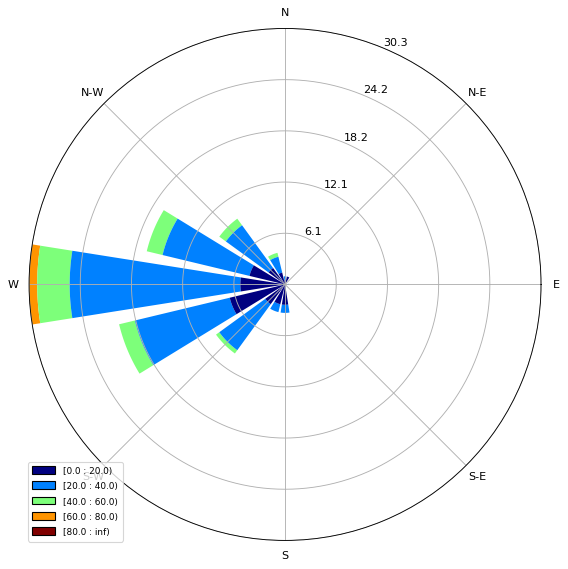

In [304]:
from windrose import WindroseAxes
import matplotlib.cm as cm

wd=snd_days_ts_A2B['500_wdir'].values
ws=snd_days_ts_A2B['500_WS'].values
ax = WindroseAxes.from_ax()
'''A stacked histogram with normed (displayed in percent) results'''
ax.bar(wd, ws, bins=np.arange(0, 100, 20), normed=True, nsector=16)
ax.set_legend()


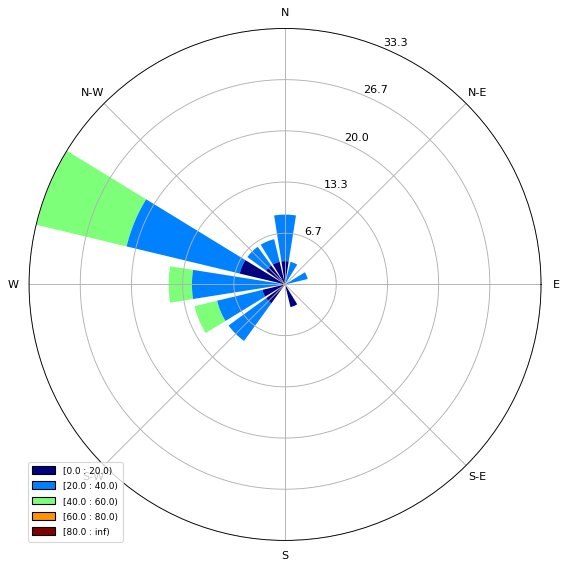

In [305]:
snd_days_ts_B2A = snd.loc[ts_B2A.index, ['700_wdir','700_WS','T500','500_wdir','500_WS','tmp_rate850_500']]

wd=snd_days_ts_B2A['500_wdir'].values
ws=snd_days_ts_B2A['500_WS'].values

ax = WindroseAxes.from_ax()
#ax.contour(wd, ws, bins=np.arange(0, 8, 1), cmap=cm.hot, lw=3)
#ax.set_legend()
'''A stacked histogram with normed (displayed in percent) results'''
ax.bar(wd, ws, bins=np.arange(0, 100, 20), normed=True, nsector=16)
ax.set_legend()